# Rootzone model: build + rich features + walk-forward
Build master_data, engineer rich features, train RF on anchor intervals, and evaluate per-step.

In [7]:
# Repo paths (works even when notebook is in scripts/)
from pathlib import Path

def find_repo_root(start=None):
    start = Path.cwd() if start is None else Path(start)
    for p in [start, *start.parents]:
        if (p / 'data').exists():
            return p
    return start

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
PLOTS = ROOT / 'plots'
PLOTS.mkdir(exist_ok=True)


In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
from collections import defaultdict
from datetime import datetime, timedelta, time
import csv
from typing import Any, Dict, List, Optional
from openpyxl import load_workbook
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt



In [9]:
from pathlib import Path
from typing import Optional

def find_repo_root(start: Optional[Path] = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for parent in [p, *p.parents]:
        if (parent / 'data').exists():
            return parent
    return p

ROOT = find_repo_root()
RAW = ROOT / 'data' / 'raw'
PROCESSED = ROOT / 'data' / 'processed'
# OUTPUTS removed; use PROCESSED or PLOTS
print('ROOT:', ROOT)
print('RAW:', RAW)

def resolve_input(filename: str) -> Path:
    # prefer data/raw; fall back to repo root for backward compatibility
    p1 = RAW / filename
    p2 = PROCESSED / filename
    p3 = ROOT / filename
    if p1.exists():
        return p1
    if p2.exists():
        return p2
    if p3.exists():
        return p3
    raise FileNotFoundError(f'Cannot find {filename} in {RAW} or {ROOT}')


ROOT: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data
RAW: C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\raw


In [10]:
# Build master_data from raw files

def floor_to_10min(dt: datetime) -> datetime:
    minute = (dt.minute // 10) * 10
    return dt.replace(minute=minute, second=0, microsecond=0)

def parse_time_flex(text: str) -> time:
    text = text.strip()
    parts = text.split(":")
    if len(parts) >= 2:
        try:
            h = int(parts[0]); m = int(parts[1]); s = int(parts[2]) if len(parts) >= 3 and parts[2] else 0
            return time(hour=h, minute=m, second=s)
        except Exception:
            pass
    for fmt in ("%H:%M:%S", "%H:%M"):
        try:
            return datetime.strptime(text, fmt).time()
        except Exception:
            continue
    raise ValueError(f"Unrecognized time format: {text}")

def parse_ts_variant(text: str, day_first: bool) -> datetime:
    norm = text.replace("-", "/").replace(".", "/").strip()
    if " " not in norm:
        raise ValueError("No space between date and time")
    date_part, time_part = norm.split(" ", 1)
    t_val = parse_time_flex(time_part)
    parts = date_part.split("/")
    if len(parts) < 3:
        raise ValueError("Date part incomplete")
    a, b, y = parts[0], parts[1], parts[2]
    if len(y) == 2:
        y = "20" + y
    if day_first:
        day, month = int(a), int(b)
    else:
        month, day = int(a), int(b)
    return datetime(int(y), month, day, t_val.hour, t_val.minute, t_val.second)

def parse_micro_ts(value: Any, prev_ts: Optional[datetime]) -> datetime:
    if isinstance(value, datetime):
        ts = value
    else:
        text = str(value).strip()
        candidates = []
        for day_first in (True, False):
            try:
                candidates.append(parse_ts_variant(text, day_first))
            except Exception:
                continue
        if not candidates:
            raise ValueError(f"Unrecognized micro-climate timestamp: {value}")
        if prev_ts is not None:
            best = None; best_delta = None
            for dt in candidates:
                delta = dt - prev_ts
                if delta >= timedelta(minutes=-5) and (best_delta is None or delta < best_delta):
                    best = dt; best_delta = delta
            ts = best if best is not None else candidates[0]
        else:
            ts = candidates[0]
    return ts

def parse_time_robust(val: Any) -> time:
    if isinstance(val, datetime):
        return val.time()
    if isinstance(val, time):
        return val
    return parse_time_flex(str(val))

def parse_date_dayfirst(text: str) -> datetime.date:
    text = text.strip()
    norm = text.replace("-", "/").replace(".", "/")
    parts = norm.split("/")
    if len(parts) >= 3:
        d, m, y = parts[0], parts[1], parts[2]
        if len(y) == 2:
            y = "20" + y
        return datetime(int(y), int(m), int(d)).date()
    for fmt in ("%d/%m/%Y", "%d/%m/%y", "%Y-%m-%d"):
        try:
            return datetime.strptime(text, fmt).date()
        except Exception:
            continue
    raise ValueError(f"Unrecognized date format: {text}")

def read_micro(path: str) -> List[Dict[str, Any]]:
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb["micro_climate_rh_t_et0"]
    rows = ws.iter_rows(values_only=True)
    next(rows)
    data = []
    prev_ts = None
    base_ts = None
    interval = timedelta(minutes=10)
    for row in rows:
        if not row or row[0] is None:
            continue
        raw_ts = parse_micro_ts(row[0], prev_ts)
        if base_ts is None:
            base_ts = raw_ts
            seq_ts = base_ts
        else:
            seq_ts = base_ts + interval * len(data)
        prev_ts = raw_ts
        data.append({
            "timestamp": seq_ts,
            "ET0": row[1],
            "internal_air_temp_c": row[2],
            "internal_rh_%": row[3],
            "internal_radiation": row[4],
        })
    return data

def read_irrigation(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    events = []
    for row in rows:
        if not row or row[0] is None:
            continue
        date_val, time_val, irr_ml, fert_type = row[0], row[1], row[2], row[3]
        if isinstance(date_val, datetime):
            date_only = date_val.date()
        else:
            parsed = None
            for fmt in ("%Y-%m-%d", "%d/%m/%Y", "%m/%d/%Y", "%d.%m.%Y", "%m.%d.%Y"):
                try:
                    parsed = datetime.strptime(str(date_val), fmt).date(); break
                except Exception:
                    continue
            if parsed is None:
                parsed = parse_date_dayfirst(str(date_val))
            date_only = parsed
        t_val = parse_time_robust(time_val)
        dt = datetime.combine(date_only, t_val)
        bucket = floor_to_10min(dt)
        fert_code = 0
        if isinstance(fert_type, str):
            f = fert_type.strip().upper()
            if f == "A":
                fert_code = 1
            elif f == "B":
                fert_code = 2
        events.append({"bucket": bucket, "irr_ml": irr_ml or 0.0, "fert_code": fert_code})
    return events

def build_irrigation_series(events):
    fert_by_bucket = {}
    irr_by_bucket = defaultdict(float)
    for ev in events:
        irr_by_bucket[ev["bucket"]] += ev["irr_ml"]
        if ev["fert_code"]:
            fert_by_bucket[ev["bucket"]] = max(fert_by_bucket.get(ev["bucket"], 0), ev["fert_code"])
    return irr_by_bucket, fert_by_bucket

def parse_ph_ec_date(val: Any) -> Optional[datetime.date]:
    if isinstance(val, datetime):
        return val.date()
    if val is None:
        return None
    s = str(val).strip()
    if not s:
        return None
    for sep in (".", "/", "-"):
        if sep in s:
            parts = s.replace("-", sep).replace("/", sep).split(sep)
            if len(parts) >= 3:
                d_raw, m_raw, y_raw = parts[0], parts[1], parts[2]
                for day_first in (True, False):
                    day, month = (d_raw, m_raw) if day_first else (m_raw, d_raw)
                    year = y_raw
                    if len(year) == 2:
                        year = "20" + year
                    try:
                        return datetime(int(year), int(month), int(day)).date()
                    except Exception:
                        continue
    for fmt in ("%Y-%m-%d", "%Y/%m/%d", "%m.%d.%Y", "%d.%m.%Y", "%m-%d-%Y", "%d-%m-%Y"):
        try:
            return datetime.strptime(s, fmt).date()
        except Exception:
            continue
    return None

def read_ph_ec(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    measurements = []
    for row in rows:
        if not row or row[1] is None:
            continue
        date_part = parse_ph_ec_date(row[1])
        time_part = row[4]
        if date_part is None or time_part is None:
            continue
        t_val = parse_time_robust(time_part)
        dt = datetime.combine(date_part, t_val)
        measurements.append({"timestamp": dt, "ph": row[2], "ec_ms": row[3]})
    return measurements

def map_ph_ec_to_micro(timestamps: List[datetime], measurements: List[Dict[str, Any]]):
    ph_list = [None] * len(timestamps)
    ec_list = [None] * len(timestamps)
    for m in measurements:
        best_idx = None; best_diff = None
        for idx, ts in enumerate(timestamps):
            diff = abs(ts - m["timestamp"])
            if diff <= timedelta(minutes=10) and (best_diff is None or diff < best_diff):
                best_idx = idx; best_diff = diff
        if best_idx is not None:
            ph_list[best_idx] = m["ph"]
            ec_list[best_idx] = m["ec_ms"]
    return ph_list, ec_list

def read_soil_temp(path: str):
    data = {}
    with open(path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            ts = datetime.strptime(row["datetime"], "%Y-%m-%d %H:%M:%S")
            data[ts] = float(row["soil_temp_pred"]) if row["soil_temp_pred"] != "" else None
    return data

def read_canopy(path: str):
    wb = load_workbook(path, read_only=True, data_only=True)
    ws = wb.active
    rows = ws.iter_rows(values_only=True)
    next(rows)
    canopy = {}
    for row in rows:
        if len(row) < 7:
            continue
        date_val = row[4]
        canopy_val = row[6]
        if date_val is None:
            continue
        if not isinstance(date_val, datetime):
            try:
                date_val = datetime.strptime(str(date_val), "%Y-%m-%d")
            except Exception:
                continue
        canopy[date_val.date()] = canopy_val
    return canopy

def build_master():
    micro = read_micro(str(resolve_input("micro_climate_rh_t_et0.xlsx")))
    events = read_irrigation(str(resolve_input("Irrigation + ALL Elemental Fractions schedule for one plant (100N).xlsx")))
    irr_by_bucket, fert_by_bucket = build_irrigation_series(events)
    ph_ec = read_ph_ec(str(resolve_input("PH+EC Final.xlsx")))
    soil_temp = read_soil_temp(str(resolve_input("soil_temp_predictions_full_range.csv")))
    canopy = read_canopy(str(resolve_input("Daily Canopy Cover Values.xlsx")))

    timestamps = [row["timestamp"] for row in micro]
    ph_list, ec_list = map_ph_ec_to_micro(timestamps, ph_ec)

    fert_flags = []
    soil_list = []
    canopy_list = []
    irr_current = []

    for i, ts in enumerate(timestamps):
        irr_now = irr_by_bucket.get(ts, 0.0)
        irr_current.append(irr_now)
        fert_flags.append(fert_by_bucket.get(ts, 0))
        soil_list.append(soil_temp.get(ts))
        canopy_list.append(canopy.get(ts.date()))

    df_out = pd.DataFrame({
        "timestamp": timestamps,
        "ET0": [r["ET0"] for r in micro],
        "internal_air_temp_c": [r["internal_air_temp_c"] for r in micro],
        "internal_rh_%": [r["internal_rh_%"] for r in micro],
        "internal_radiation": [r["internal_radiation"] for r in micro],
        "irrigation_ml_current": irr_current,
        "fertilization_flag": fert_flags,
        "ph": ph_list,
        "ec_ms": ec_list,
        "soil_temp_pred": soil_list,
        "canopy_cover": canopy_list,
    })
    df_out = df_out.sort_values("timestamp").set_index("timestamp")
    out_path = PROCESSED / "master_data.csv"
    df_out.to_csv(out_path, index=True)
    print(f"Wrote {out_path} with {len(df_out)} rows")
    return df_out

print("Building master_data ...")
df = build_master()


Building master_data ...
Wrote C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data.csv with 16682 rows


In [11]:
# Rich feature engineering on master (10-minute timeline)
pi = np.pi
hours = df.index.hour
days = df.index.dayofyear

feat_dict = {}
feat_dict['hour_sin'] = np.sin(2*pi*hours/24)
feat_dict['hour_cos'] = np.cos(2*pi*hours/24)
feat_dict['doy_sin'] = np.sin(2*pi*days/365)
feat_dict['doy_cos'] = np.cos(2*pi*days/365)
feat_dict['is_weekend'] = df.index.weekday.isin([5,6]).astype(int)

irr_amt = df['irrigation_ml_current'].fillna(0)
irr_flag = (irr_amt > 0).astype(int)
fert_flag = (df['fertilization_flag'].fillna(0) > 0).astype(int)
fert_a = (df['fertilization_flag'] == 1).astype(int)
fert_b = (df['fertilization_flag'] == 2).astype(int)
feat_dict['irrigation_flag'] = irr_flag
feat_dict['fertigation_flag'] = fert_flag
feat_dict['fert_a_flag'] = fert_a
feat_dict['fert_b_flag'] = fert_b

idx_series = pd.Series(df.index, index=df.index)
last_irr_time = pd.Series(df.index.where(irr_flag==1), index=df.index).ffill()
last_fert_time = pd.Series(df.index.where(fert_flag==1), index=df.index).ffill()
feat_dict['time_since_irrigation_minutes'] = (idx_series - last_irr_time).dt.total_seconds() / 60
feat_dict['time_since_fertigation_minutes'] = (idx_series - last_fert_time).dt.total_seconds() / 60

windows = {6:'1h', 18:'3h', 36:'6h', 144:'24h'}
for win,name in windows.items():
    feat_dict[f'irr_sum_{name}'] = irr_amt.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_count_{name}'] = irr_flag.rolling(win, min_periods=1).sum()
    feat_dict[f'irr_flag_density_{name}'] = feat_dict[f'irr_flag_count_{name}'] / win
    if win in (36,144):
        feat_dict[f'fert_count_{name}'] = fert_flag.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_a_count_{name}'] = fert_a.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_b_count_{name}'] = fert_b.rolling(win, min_periods=1).sum()
        feat_dict[f'fert_density_{name}'] = feat_dict[f'fert_count_{name}'] / win

climate_cols = ['internal_air_temp_c','internal_rh_%','internal_radiation','ET0']
for col in climate_cols:
    for win,name in windows.items():
        feat_dict[f'{col}_roll_mean_{name}'] = df[col].rolling(win, min_periods=1).mean()
        feat_dict[f'{col}_roll_std_{name}'] = df[col].rolling(win, min_periods=1).std()
        feat_dict[f'{col}_roll_min_{name}'] = df[col].rolling(win, min_periods=1).min()
        feat_dict[f'{col}_roll_max_{name}'] = df[col].rolling(win, min_periods=1).max()
    feat_dict[f'{col}_diff_10m'] = df[col].diff()
    feat_dict[f'{col}_diff_1h'] = df[col] - df[col].shift(6)
    feat_dict[f'{col}_slope_1h'] = (df[col] - df[col].shift(6)) / 6
    feat_dict[f'{col}_slope_3h'] = (df[col] - df[col].shift(18)) / 18

feat_dict['vpd_proxy'] = (1 - df['internal_rh_%']/100.0) * df['internal_air_temp_c']

if 'soil_temp_pred' in df.columns:
    for win,name in {36:'6h', 144:'24h'}.items():
        feat_dict[f'soil_temp_mean_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).mean()
        feat_dict[f'soil_temp_std_{name}'] = df['soil_temp_pred'].rolling(win, min_periods=1).std()
        feat_dict[f'soil_temp_slope_{name}'] = (df['soil_temp_pred'] - df['soil_temp_pred'].shift(win)) / win


feat_dict['rad_x_temp'] = df['internal_radiation'] * df['internal_air_temp_c']
feat_dict['et0_x_temp'] = df['ET0'] * df['internal_air_temp_c']
feat_dict['rh_x_temp'] = df['internal_rh_%'] * df['internal_air_temp_c']
feat_dict['irr6h_x_radiation'] = feat_dict['irr_sum_6h'] * df['internal_radiation']

feat_df = pd.DataFrame(feat_dict, index=df.index)
# Save full master timeline with engineered features (no filtering on pH/EC)
master_with_features = df.join(pd.DataFrame(feat_dict, index=df.index))
master_features_path = PROCESSED / 'master_data_with_features.csv'
master_with_features.to_csv(master_features_path)
print('Saved', master_features_path, 'rows:', len(master_with_features), 'cols:', master_with_features.shape[1])
mask_all = feat_df.notna().all(axis=1)
feat_df = feat_df.loc[mask_all]
df_feat = df.loc[mask_all]
print('feature rows', len(feat_df))


Saved C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\master_data_with_features.csv rows: 16682 cols: 132
feature rows 16512


# Realtime 10-minute predictions
Predict pH and EC every 10 minutes starting from the first timestamp with real pH/EC.
At each step, predict; when ground truth exists, report that row's error, then update the model and continue.


In [12]:
import warnings
# Suppress noisy sklearn parallel warning as early as possible
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings(
    'ignore',
    message=r'sklearn\.utils\.parallel\.delayed should be used with sklearn\.utils\.parallel\.Parallel.*',
    category=UserWarning,
    module=r'sklearn\.utils\.parallel'
)
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*Parallel.*')

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use engineered features; forward-fill to avoid gaps, no pH/EC leakage.
# Use full engineered feature set for more context; add prev-state features separately.
base_features = list(feat_df.columns)
feature_frame = master_with_features[base_features].copy().ffill().fillna(0)

cols_with_prev = base_features + ['ph_prev', 'ec_prev']
rf_params = dict(
    n_estimators=200,
    max_depth=12,
    min_samples_leaf=3,
    max_features=None,
    max_samples=None,
    random_state=42,
    n_jobs=-1,
)

min_train_points = 20  # require this many true samples before fitting
model = None
X_train_rows, y_train_rows = [], []
X_train_final = None
y_train_final = None
records = []
ph_state = None
ec_state = None

for ts in feature_frame.index:
    # Initialize state on the first available true sample
    if (ph_state is None or ec_state is None) and pd.notna(df.loc[ts, 'ph']) and pd.notna(df.loc[ts, 'ec_ms']):
        ph_state = float(df.loc[ts, 'ph'])
        ec_state = float(df.loc[ts, 'ec_ms'])

    if ph_state is None or ec_state is None:
        continue

    # Build one-row DataFrame with consistent column names
    feature_row = feature_frame.loc[ts].astype(float)
    x_vec = pd.DataFrame([[*feature_row.values, ph_state, ec_state]], columns=cols_with_prev)

    if model is not None:
        pred = model.predict(x_vec)[0]
        ph_pred, ec_pred = float(pred[0]), float(pred[1])
    else:
        ph_pred, ec_pred = ph_state, ec_state  # hold state until trained

    ph_true = df.loc[ts, 'ph']
    ec_true = df.loc[ts, 'ec_ms']
    has_truth = pd.notna(ph_true) and pd.notna(ec_true)

    ph_abs_err = ec_abs_err = None
    if has_truth and model is not None:
        ph_abs_err = abs(ph_pred - float(ph_true))
        ec_abs_err = abs(ec_pred - float(ec_true))
        print(f"{ts}: ph_true={float(ph_true):.3f}, ph_pred={ph_pred:.3f}, ec_true={float(ec_true):.3f}, ec_pred={ec_pred:.3f}, ph_abs_err={ph_abs_err:.3f}, ec_abs_err={ec_abs_err:.3f}")

    records.append({
        'timestamp': ts,
        'ph_pred': ph_pred,
        'ec_pred': ec_pred,
        'ph_true': float(ph_true) if has_truth else None,
        'ec_true': float(ec_true) if has_truth else None,
        'ph_abs_error': ph_abs_err,
        'ec_abs_error': ec_abs_err,
        'trained_points': len(y_train_rows),
        'model_ready': model is not None,
    })

    if has_truth:
        # Update state with truth, then train
        ph_state, ec_state = float(ph_true), float(ec_true)
        X_train_rows.append(x_vec.iloc[0])
        y_train_rows.append([ph_state, ec_state])
        if len(y_train_rows) >= min_train_points:
            base = RandomForestRegressor(**rf_params)
            model = MultiOutputRegressor(base)
            X_df = pd.DataFrame(X_train_rows, columns=cols_with_prev)
            y_df = pd.DataFrame(y_train_rows, columns=['ph', 'ec'])
            model.fit(X_df, y_df)
            X_train_final = X_df.copy()
            y_train_final = y_df.copy()
    else:
        # No truth: propagate prediction as the new state
        ph_state, ec_state = ph_pred, ec_pred

pred_step_df = pd.DataFrame(records).set_index('timestamp')
pred_step_df['gap_minutes'] = pred_step_df.index.to_series().diff().dt.total_seconds().div(60).fillna(0)
print('Timeline predictions:', len(pred_step_df), 'rows')
display(pred_step_df.head(20))

with_truth = pred_step_df.dropna(subset=['ph_true', 'ec_true'])
if len(with_truth) > 0:
    def rmse(a, b):
        return float(np.sqrt(mean_squared_error(a, b)))
    print('\nMetrics on timestamps with ground truth:')
    print('pH MAE', mean_absolute_error(with_truth['ph_true'], with_truth['ph_pred']), 'RMSE', rmse(with_truth['ph_true'], with_truth['ph_pred']), 'R2', r2_score(with_truth['ph_true'], with_truth['ph_pred']))
    print('EC MAE', mean_absolute_error(with_truth['ec_true'], with_truth['ec_pred']), 'RMSE', rmse(with_truth['ec_true'], with_truth['ec_pred']), 'R2', r2_score(with_truth['ec_true'], with_truth['ec_pred']))
    # Relative MAE (%) ignoring zeros
    rel_ph = (with_truth['ph_abs_error'] / with_truth['ph_true'].abs().replace(0, np.nan)) * 100
    rel_ec = (with_truth['ec_abs_error'] / with_truth['ec_true'].abs().replace(0, np.nan)) * 100
    print('pH relative MAE %:', float(rel_ph.mean(skipna=True)))
    print('EC relative MAE %:', float(rel_ec.mean(skipna=True)))
    # Metrics by gap minutes bins
    with_truth['gap_bin'] = pd.qcut(with_truth['gap_minutes'], q=min(4, len(with_truth)), duplicates='drop')
    gap_metrics = []
    for gb, grp in with_truth.groupby('gap_bin'):
        gap_metrics.append({
            'gap_bin': gb,
            'count': len(grp),
            'ph_mae': mean_absolute_error(grp['ph_true'], grp['ph_pred']),
            'ec_mae': mean_absolute_error(grp['ec_true'], grp['ec_pred']),
            'ph_rel_mae_pct': (grp['ph_abs_error'] / grp['ph_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
            'ec_rel_mae_pct': (grp['ec_abs_error'] / grp['ec_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
        })
    gap_metrics_df = pd.DataFrame(gap_metrics)
    print('\nMetrics by gap bin:')
    display(gap_metrics_df)
    # Metrics by true value bins
    ph_bins = pd.qcut(with_truth['ph_true'], q=min(4, len(with_truth)), duplicates='drop')
    ec_bins = pd.qcut(with_truth['ec_true'], q=min(4, len(with_truth)), duplicates='drop')
    ph_bin_metrics = with_truth.groupby(ph_bins).apply(lambda g: pd.Series({
        'count': len(g),
        'mae': mean_absolute_error(g['ph_true'], g['ph_pred']),
        'rel_mae_pct': (g['ph_abs_error'] / g['ph_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
    })).reset_index().rename(columns={'ph_true': 'ph_bin'})
    ec_bin_metrics = with_truth.groupby(ec_bins).apply(lambda g: pd.Series({
        'count': len(g),
        'mae': mean_absolute_error(g['ec_true'], g['ec_pred']),
        'rel_mae_pct': (g['ec_abs_error'] / g['ec_true'].abs().replace(0, np.nan) * 100).mean(skipna=True),
    })).reset_index().rename(columns={'ec_true': 'ec_bin'})
    print('\nMetrics by pH true bins:')
    display(ph_bin_metrics)
    print('\nMetrics by EC true bins:')
    display(ec_bin_metrics)
    display(with_truth[['ph_true', 'ph_pred', 'ph_abs_error', 'ec_true', 'ec_pred', 'ec_abs_error']].head(30))
else:
    print('No timestamps with ground truth were found.')

# Persist predictions to disk to avoid rerun cost
PROCESSED.mkdir(parents=True, exist_ok=True)
pred_csv = PROCESSED / 'rf_rootzone_realtime_predictions.csv'
pred_step_df.to_csv(pred_csv)
print('Saved predictions to', pred_csv)
# Store trained feature/target matrices for later analysis
if X_train_final is not None and y_train_final is not None:
    X_train_final.to_csv(PROCESSED / 'rf_rootzone_realtime_features.csv', index=False)
    y_train_final.to_csv(PROCESSED / 'rf_rootzone_realtime_targets.csv', index=False)
    print('Saved training matrices to processed directory')
else:
    print('Model never trained (insufficient ground truth).')


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-05 14:10:00: ph_true=8.500, ph_pred=8.383, ec_true=2.470, ec_pred=1.033, ph_abs_err=0.117, ec_abs_err=1.437
2025-08-06 10:00:00: ph_true=7.750, ph_pred=7.500, ec_true=1.045, ec_pred=1.264, ph_abs_err=0.250, ec_abs_err=0.219
2025-08-06 16:30:00: ph_true=8.830, ph_pred=7.967, ec_true=2.250, ec_pred=1.861, ph_abs_err=0.863, ec_abs_err=0.389
2025-08-07 10:00:00: ph_true=8.050, ph_pred=7.374, ec_true=2.360, ec_pred=0.976, ph_abs_err=0.676, ec_abs_err=1.384
2025-08-07 13:00:00: ph_true=8.110, ph_pred=7.499, ec_true=2.300, ec_pred=1.404, ph_abs_err=0.611, ec_abs_err=0.896
2025-08-10 08:20:00: ph_true=7.480, ph_pred=7.898, ec_true=2.180, ec_pred=1.611, ph_abs_err=0.418, ec_abs_err=0.569
2025-08-10 15:20:00: ph_true=8.700, ph_pred=8.181, ec_true=4.180, ec_pred=1.893, ph_abs_err=0.519, ec_abs_err=2.287
2025-08-11 08:10:00: ph_true=7.440, ph_pred=7.745, ec_true=3.290, ec_pred=2.051, ph_abs_err=0.305, ec_abs_err=1.239
2025-08-12 08:30:00: ph_true=7.810, ph_pred=8.090, ec_true=1.473, ec_pre

c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-17 08:10:00: ph_true=7.070, ph_pred=8.214, ec_true=1.145, ec_pred=2.043, ph_abs_err=1.144, ec_abs_err=0.898
2025-08-17 12:40:00: ph_true=9.300, ph_pred=7.767, ec_true=2.680, ec_pred=2.193, ph_abs_err=1.533, ec_abs_err=0.487
2025-08-18 08:30:00: ph_true=8.290, ph_pred=7.770, ec_true=1.932, ec_pred=1.999, ph_abs_err=0.520, ec_abs_err=0.067
2025-08-18 14:40:00: ph_true=9.190, ph_pred=8.524, ec_true=2.930, ec_pred=2.410, ph_abs_err=0.666, ec_abs_err=0.520
2025-08-19 12:30:00: ph_true=9.610, ph_pred=8.068, ec_true=1.752, ec_pred=2.298, ph_abs_err=1.542, ec_abs_err=0.546
2025-08-19 17:30:00: ph_true=9.080, ph_pred=8.649, ec_true=1.354, ec_pred=2.406, ph_abs_err=0.431, ec_abs_err=1.052
2025-08-20 12:00:00: ph_true=9.210, ph_pred=8.090, ec_true=0.912, ec_pred=2.346, ph_abs_err=1.120, ec_abs_err=1.434
2025-08-20 12:20:00: ph_true=8.370, ph_pred=8.596, ec_true=0.845, ec_pred=1.721, ph_abs_err=0.226, ec_abs_err=0.876
2025-08-21 13:00:00: ph_true=8.140, ph_pred=8.341, ec_true=0.738, ec_pre

c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-08-26 12:00:00: ph_true=7.370, ph_pred=8.366, ec_true=0.266, ec_pred=1.004, ph_abs_err=0.996, ec_abs_err=0.738
2025-08-26 16:30:00: ph_true=7.360, ph_pred=8.301, ec_true=0.314, ec_pred=0.770, ph_abs_err=0.941, ec_abs_err=0.456
2025-08-27 11:40:00: ph_true=7.760, ph_pred=7.853, ec_true=0.181, ec_pred=0.881, ph_abs_err=0.093, ec_abs_err=0.700
2025-08-27 14:10:00: ph_true=8.930, ph_pred=7.793, ec_true=0.294, ec_pred=0.552, ph_abs_err=1.137, ec_abs_err=0.258
2025-08-28 13:30:00: ph_true=7.620, ph_pred=8.375, ec_true=0.358, ec_pred=0.603, ph_abs_err=0.755, ec_abs_err=0.245
2025-08-28 15:00:00: ph_true=10.290, ph_pred=8.017, ec_true=0.174, ec_pred=0.397, ph_abs_err=2.273, ec_abs_err=0.223
2025-08-31 08:20:00: ph_true=7.730, ph_pred=7.843, ec_true=0.180, ec_pred=0.598, ph_abs_err=0.113, ec_abs_err=0.418
2025-08-31 12:30:00: ph_true=10.490, ph_pred=8.220, ec_true=0.167, ec_pred=1.573, ph_abs_err=2.270, ec_abs_err=1.406
2025-09-01 08:30:00: ph_true=9.760, ph_pred=7.868, ec_true=0.292, ec_p

c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-18 13:10:00: ph_true=7.080, ph_pred=9.114, ec_true=0.662, ec_pred=0.452, ph_abs_err=2.034, ec_abs_err=0.210
2025-09-18 14:10:00: ph_true=6.650, ph_pred=8.908, ec_true=0.709, ec_pred=0.521, ph_abs_err=2.258, ec_abs_err=0.188
2025-09-18 15:10:00: ph_true=6.800, ph_pred=8.946, ec_true=0.680, ec_pred=0.616, ph_abs_err=2.146, ec_abs_err=0.064


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\utils\parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\sklearn\u

2025-09-21 06:30:00: ph_true=6.190, ph_pred=8.144, ec_true=0.501, ec_pred=0.464, ph_abs_err=1.954, ec_abs_err=0.037
2025-09-21 07:20:00: ph_true=4.750, ph_pred=7.705, ec_true=4.230, ec_pred=0.490, ph_abs_err=2.955, ec_abs_err=3.740
2025-09-21 08:40:00: ph_true=4.750, ph_pred=7.707, ec_true=4.970, ec_pred=0.943, ph_abs_err=2.957, ec_abs_err=4.027
2025-09-21 10:30:00: ph_true=5.170, ph_pred=7.061, ec_true=4.520, ec_pred=1.497, ph_abs_err=1.891, ec_abs_err=3.023
2025-09-21 11:40:00: ph_true=5.250, ph_pred=6.121, ec_true=4.400, ec_pred=2.705, ph_abs_err=0.871, ec_abs_err=1.695
2025-09-21 13:40:00: ph_true=5.330, ph_pred=6.063, ec_true=4.530, ec_pred=3.670, ph_abs_err=0.733, ec_abs_err=0.860
2025-09-21 15:30:00: ph_true=5.400, ph_pred=5.979, ec_true=3.870, ec_pred=4.042, ph_abs_err=0.579, ec_abs_err=0.172
Timeline predictions: 14601 rows


,ph_pred,ec_pred,ph_true,ec_true,ph_abs_error,ec_abs_error,trained_points,model_ready,gap_minutes
timestamp,,,,,,,,,
2025-06-12 11:50:00,6.71,0.29,6.71,0.29,NaN,NaN,0,False,0.0
2025-06-12 12:00:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:10:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:20:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:30:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:40:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 12:50:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 13:00:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0
2025-06-12 13:10:00,6.71,0.29,NaN,NaN,NaN,NaN,1,False,10.0



Metrics on timestamps with ground truth:
pH MAE 0.7200495183168005 RMSE 0.9739215044329352 R2 0.4404916601660742
EC MAE 0.5123407655684656 RMSE 0.8978477965318381 R2 0.41140372483621135
pH relative MAE %: 9.739540337172283
EC relative MAE %: 82.21761098087305

Metrics by gap bin:


C:\Users\edene\AppData\Local\Temp\ipykernel_15376\1543945484.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_truth['gap_bin'] = pd.qcut(with_truth['gap_minutes'], q=min(4, len(with_truth)), duplicates='drop')
C:\Users\edene\AppData\Local\Temp\ipykernel_15376\1543945484.py:121: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for gb, grp in with_truth.groupby('gap_bin'):


,gap_bin,count,ph_mae,ec_mae,ph_rel_mae_pct,ec_rel_mae_pct
0,"(-0.001, 10.0]",109,0.72005,0.512341,9.73954,82.217611



Metrics by pH true bins:


C:\Users\edene\AppData\Local\Temp\ipykernel_15376\1543945484.py:136: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ph_bin_metrics = with_truth.groupby(ph_bins).apply(lambda g: pd.Series({
C:\Users\edene\AppData\Local\Temp\ipykernel_15376\1543945484.py:141: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ec_bin_metrics = with_truth.groupby(ec_bins).apply(lambda g: pd.Series({


,ph_bin,count,mae,rel_mae_pct
0,"(4.749, 7.65]",28.0,1.056560,22.611120
1,"(7.65, 8.3]",27.0,0.538048,5.530239
2,"(8.3, 9.39]",27.0,0.498165,5.482584
3,"(9.39, 10.49]",27.0,0.774962,7.500808



Metrics by EC true bins:


,ec_bin,count,mae,rel_mae_pct
0,"(0.127, 0.302]",28.0,0.285179,153.736217
1,"(0.302, 0.36]",27.0,0.201155,64.120782
2,"(0.36, 1.045]",27.0,0.399229,54.929496
3,"(1.045, 4.97]",27.0,1.172214,38.837554


,ph_true,ph_pred,ph_abs_error,ec_true,ec_pred,ec_abs_error
timestamp,,,,,,
2025-06-12 11:50:00,6.71,6.710000,NaN,0.2900,0.290000,NaN
2025-06-29 12:10:00,8.20,6.710000,NaN,0.2900,0.290000,NaN
2025-07-07 11:00:00,7.11,8.200000,NaN,0.3610,0.290000,NaN
2025-07-16 14:00:00,6.75,7.110000,NaN,0.3870,0.361000,NaN
2025-07-20 12:50:00,6.86,6.750000,NaN,0.5200,0.387000,NaN
2025-07-23 11:30:00,6.81,6.860000,NaN,0.3250,0.520000,NaN
2025-07-23 17:30:00,8.14,6.810000,NaN,0.3605,0.325000,NaN
2025-07-24 11:00:00,9.49,8.140000,NaN,0.5821,0.360500,NaN
2025-07-24 15:10:00,9.22,9.490000,NaN,0.5503,0.582100,NaN


Saved predictions to C:\Users\edene\OneDrive\שולחן העבודה\Predictive_Modeling_Of_Rootzone_Variables_Using_Greenhouse_Data\data\processed\rf_rootzone_realtime_predictions.csv
Saved training matrices to processed directory


## Feature importance (final model)


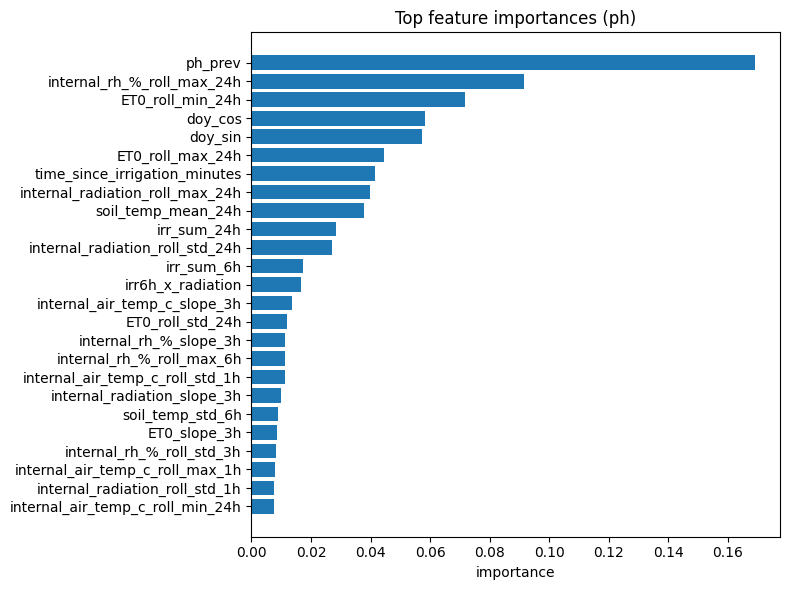

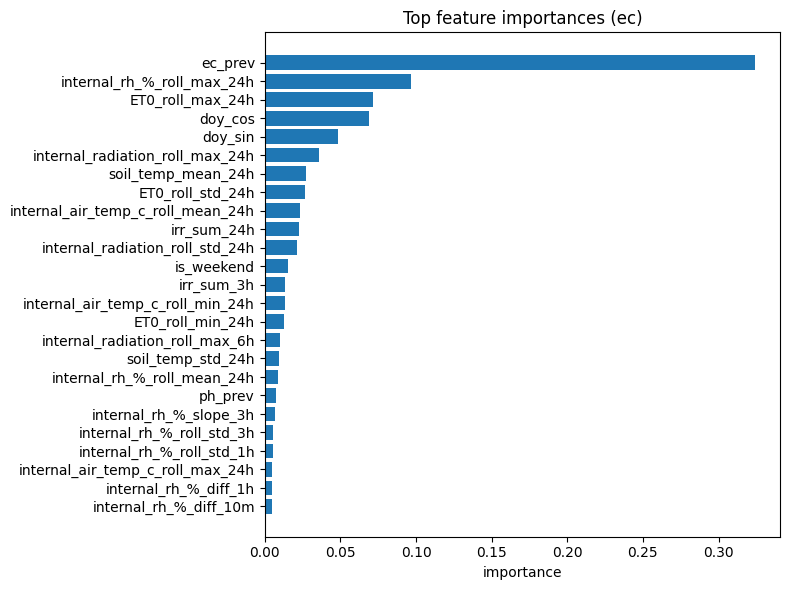

In [13]:
if model is None or X_train_final is None:
    print('No trained model available for importances.')
else:
    import matplotlib.pyplot as plt
    for tgt_name, est in zip(['ph','ec'], model.estimators_):
        imp = pd.Series(est.feature_importances_, index=cols_with_prev).sort_values(ascending=False)
        top = imp.head(25)
        plt.figure(figsize=(8,6))
        plt.barh(top.index[::-1], top.values[::-1])
        plt.title(f'Top feature importances ({tgt_name})')
        plt.xlabel('importance')
        plt.tight_layout()
        plt.show()


## SHAP (final model)


c:\Users\edene\anaconda3\envs\tf-cpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


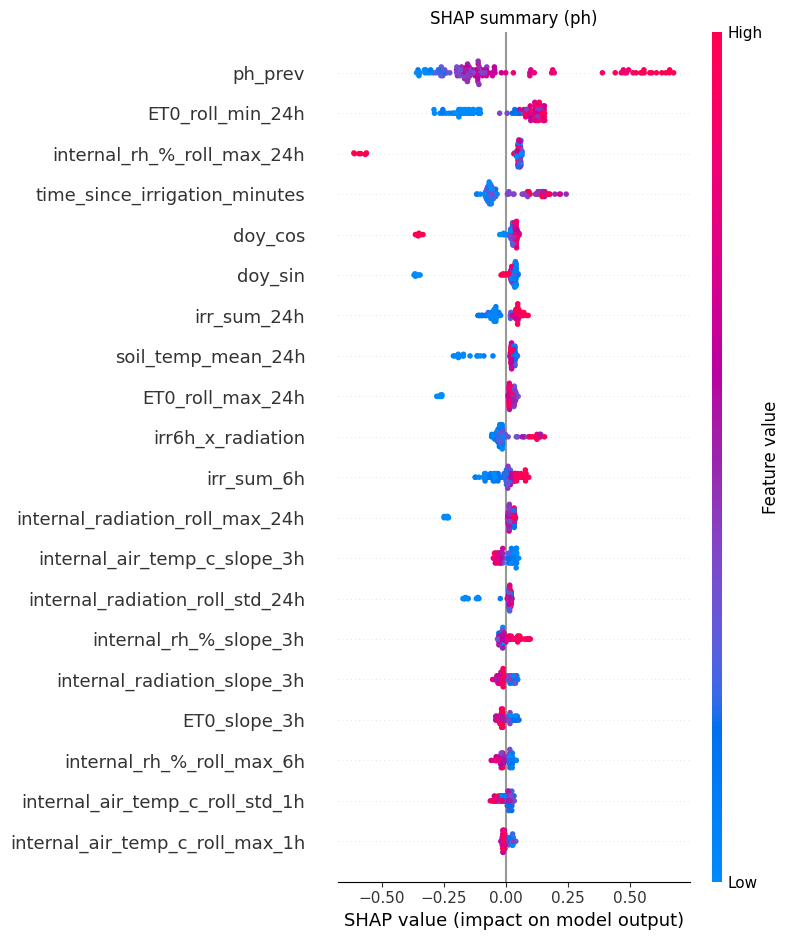

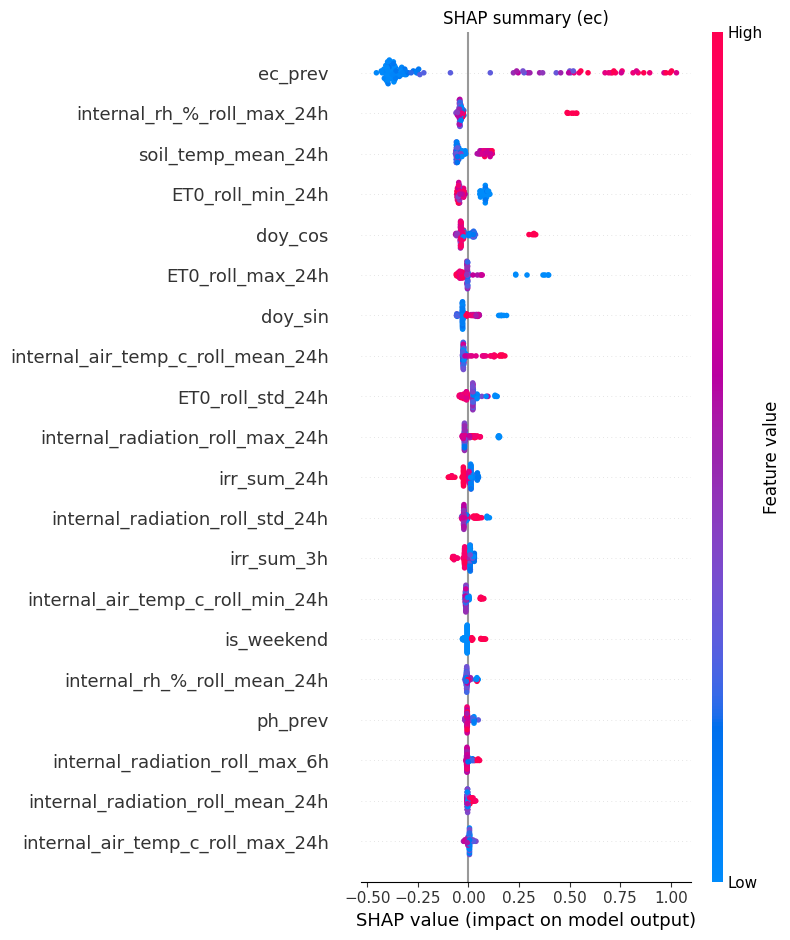

In [14]:
try:
    import shap
except ImportError as e:
    print('shap is not installed. Install with: pip install shap')
    shap = None

if shap is None or model is None or X_train_final is None:
    pass
else:
    sample = X_train_final.sample(n=min(400, len(X_train_final)), random_state=42)
    for tgt_name, est in zip(['ph','ec'], model.estimators_):
        explainer = shap.TreeExplainer(est)
        shap_values = explainer.shap_values(sample)
        shap.summary_plot(shap_values, sample, show=False)
        import matplotlib.pyplot as plt
        plt.title(f'SHAP summary ({tgt_name})')
        plt.tight_layout()
        plt.show()
